### Import Packages

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

### NPRW DATA

Count the number of manually identified calls

In [2]:
# Path to directories of metadata
metadata_path = "D:/WHOI Storage/data"

# Directories containing the metadata
directories = ["Right_Gunshot_Selections", "RightUpsweeps_Selections"]

num_calls = 0

for direct in directories:

    # Get full path to directory and the files
    dir_path = os.path.join(metadata_path, direct)
    files = os.listdir(dir_path)

    for file in files:

        # Get
        df = pd.read_csv(os.path.join(dir_path, file), sep='\t')
        df.columns = ['Selection',
                      'View',
                      'Channel',
                      'BeginTime',
                      'EndTime',
                      'LowFreq',
                      'HighFreq',
                      'Annotation']

        num_calls += len(df)

print("Ground Truth # Calls:", num_calls)

Ground Truth # Calls: 648


Count each category of labeled call: true positive (TP), false positive (FP), false negative (FN), true negative (TN)

In [22]:
# Path to the no threshold case
no_thresh_path = "D:/WHOI Storage/scan_results/NPRW/NoThresh"

# Get and count TP/FP
df_TP_FP = pd.read_csv(os.path.join(no_thresh_path, "TP-FP/M2_Right_GunshotSong_And_RightUpsweep.csv"), index_col=[0])
FP = df_TP_FP.groupby(['Label'])["Prob"].count()[0]
TP = df_TP_FP.groupby(['Label'])["Prob"].count()[1]

print("FP: {}\nTP: {}".format(FP, TP))

# Get and count TN/FN
df_TN_FN = pd.read_csv(os.path.join(no_thresh_path, "TN-FN/M2_Right_GunshotSong_And_RightUpsweep_large.csv"), index_col=[0])
TN = df_TN_FN.groupby(['Label'])["Prob"].count()[4]
FN = df_TN_FN.groupby(['Label'])["Prob"].count()[3]

print("FN: {}\nTN: {}".format(FN, TN))

FP: 14
TP: 55
FN: 382
TN: 37049


Define a function that uses a threshold to count the four categories **TP, FP, FN, TN** based on how the CNN's assigned probability compares. This can be used to calculate an Precision-Recall (P-R) Curve, Receiver Operating Characteristic (ROC) curve, etc.

In [50]:
def TP_FP_Thresh(path, thresh):
    
    # Read the dataframe
    df_TP_FP = pd.read_csv(path, index_col=[0])

    df_TP = df_TP_FP.query("(Prob >= {} and Label == 1) or (Prob >= {} and Label == 3)".format(thresh, thresh))
    TP = len(df_TP)

    df_FP = df_TP_FP.query("(Prob >= {} and Label == 0) or (Prob >= {} and Label == 4)".format(thresh, thresh))
    FP = len(df_FP)

    df_FN = df_TP_FP.query("(Prob <= {} and Label == 1) or (Prob <= {} and Label == 3)".format(thresh, thresh))
    FN = len(df_FN)

    df_TP = df_TP_FP.query("(Prob <= {} and Label == 0) or (Prob <= {} and Label == 4)".format(thresh, thresh))
    TN = len(df_TP)

    return TP, FP, TN, FN

step = 0.01
TPR_list = list()
FPR_list = list()
TP_list = list()
TP_FP_list = list()
precision_list = list()
recall_list = list()
for thresh in np.arange(0.05, 1, step):
    
    TP1, FP1, TN1, FN1 = TP_FP_Thresh(os.path.join(no_thresh_path, "TP-FP/M2_Right_GunshotSong_And_RightUpsweep.csv"), thresh)
    TP2, FP2, TN2, FN2 = TP_FP_Thresh(os.path.join(no_thresh_path, "TN-FN/M2_Right_GunshotSong_And_RightUpsweep_large.csv"), thresh)
    
    TP = TP1 + TP2
    FP = FP1 + FP2
    TN = TN1 + TN2
    FN = FN1 + FN2
    #
    # TPR = (TP)/(TP + FN)
    # FPR = (FP)/(FP + TN)
    #
    # TPR_list.append(TPR)
    # FPR_list.append(FPR)
    #
    # TP_list.append(TP)
    # TP_FP_list.append(TP + FP)
    #
    # precision = (TP)/(TP + FP)
    # recall = (TP)/(TP + FN)

    precision = TP / (TP + FP)
    recall = TP / num_calls

    precision_list.append(precision)
    recall_list.append(recall)

Plot the Precision-Recall Curve

Text(0.5, 1.0, 'North Pacific Right Whale Data Precision/Recall')

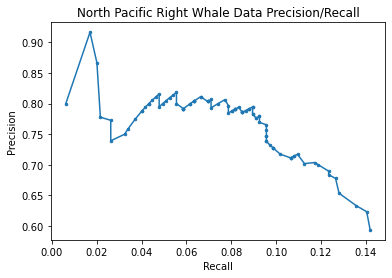

In [51]:
plt.plot(recall_list, precision_list, '-o', markersize=2.5)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("North Pacific Right Whale Data Precision-Recall")